# Generate grid borders

This notebook aims to solve a small bug that prevents the grid from working properly from the data as is. 
As can be seen in the picture, those cells laying between two tiles from the original satellite image will not be assigned to any of both datasets, as the condition cell.within(dataset_extent) is not True.

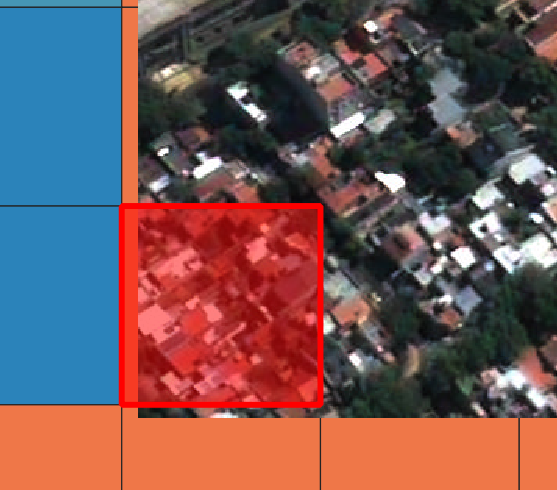

To avoid fixing the code, I'll generate a few small datasets that merges the two tiles and stores data from that small band.

In [1]:
import os
import sys
sys.path.append('..')  # Add the parent directory to the sys.path
import utils
import xarray as xr 
from shapely.geometry import box

img_paths = r"D:\Maestría\Tesis\Repo\data\data_in\Compressed\2013"

files = os.listdir(img_paths)
files = [f for f in files if f.endswith(".tif")]
files
datasets = {
        f.replace(".tif", ""): (xr.open_dataset(os.path.join(img_paths, f)))
        for f in files
}
extents = {name: utils.get_dataset_extent(ds) for name, ds in datasets.items()}

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.

In [5]:
import pickle
file = r"C:\Users\ofici\comb_6741390101_R1C1_6741390101_R1C2.pkl"
with open(file, "rb") as f:
    result_ds = pickle.load(f)
result_ds

ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'

In [3]:

import pickle
ds = xr.open_dataset(os.path.join(img_paths, files[0]))
pkl = pickle.dumps(ds, protocol=-1)
with open(f"test.pkl", "wb") as f:
    f.write(pkl)

print("Pickled data saved to: ", "test.pkl")


Pickled data saved to:  test.pkl


c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [19]:
def remove_overlapping_pixels(main, to_crop):

    main_extent = utils.get_dataset_extent(main)
    will_be_cropeed_extent = utils.get_dataset_extent(to_crop)
    cropped_extent = will_be_cropeed_extent.difference(main_extent)

    # Crop dataset
    min_lon, min_lat, max_lon, max_lat = cropped_extent.bounds
    cropped = to_crop.sel(x=slice(min_lon, max_lon), y=slice(max_lat,min_lat))

    return cropped

def add_datasets_combinations(datasets):
    from shapely.geometry import box

    extents = {name: utils.get_dataset_extent(ds) for name, ds in datasets.items()}
    to_remove = []
    combinations = {}

    for ds_name, ds in datasets.items():
        # Construyo lista de datasets que intersectan con ds_name
        capture_ds_name = ds_name.split("_")[1]
        ds_extent = extents[ds_name]
        buffered_extent = ds_extent.buffer(0.005).envelope
        xmin, ymin, xmax, ymax = buffered_extent.bounds

        intersecting = []
        for name, ds_extent in extents.items():
            capture_name = name.split("_")[1]
            if (
                ds_extent.intersects(buffered_extent)
                & (name != ds_name)
                & (capture_ds_name == capture_name)
            ):
                intersecting += [name]

        # Recorto datasets de intersection (buffer de 1080px):
        cropped_datasets = {}
        for intersection in intersecting:
            intersecting_ds = datasets[intersection]
            cropped_datasets[intersection] = intersecting_ds.sel(
                x=slice(xmin, xmax), y=slice(ymax, ymin)
            )

        # Armo xarray con la intersección de a pares
        for cropped_name, cropped_ds in cropped_datasets.items():

            names = [ds_name, cropped_name]
            names = [name.replace("pansharpened_", "") for name in names]
            names.sort()
            combined_name = "comb_" + "_".join(names)

            if combined_name not in combinations:
                polygon = box(
                    cropped_ds.x.min(),
                    cropped_ds.y.min(),
                    cropped_ds.x.max(),
                    cropped_ds.y.max(),
                )
                buffered_extent = polygon.buffer(0.005).envelope
                xmin, ymin, xmax, ymax = buffered_extent.bounds

                cropped_main_ds = ds.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))
                cropped_ds = remove_overlapping_pixels(cropped_main_ds, cropped_ds)

                # print(ds_name, cropped_name)
                # print(cropped_main_ds)
                # print(cropped_ds)

                try:
                    result_ds = xr.combine_by_coords(
                        [cropped_main_ds, cropped_ds], combine_attrs="override"
                    )
                    result_ds.to_netcdf(f"{combined_name}.nc")
                    print(f"{combined_name}.nc creado")
                    to_remove += [combined_name]
                    # combinations[combined_name] = xr.open_dataset(combined_name)
                except Exception as e:
                    print(e)

    all_datasets = combinations | datasets
    for file in to_remove:
        os.remove(file)
        
    return all_datasets

In [20]:
datasets = add_datasets_combinations(datasets)
# extents = {name: utils.get_dataset_extent(ds) for name, ds in datasets.items()}

In [48]:
import pickle
pkl = pickle.dumps(datasets, protocol=-1)

# pickle.loads(pkl)



In [46]:
datasets.isel(x=1000, y=3500)

<xarray.Dataset>
Dimensions:      (band: 4)
Coordinates:
  * band         (band) int32 1 2 3 4
    x            float64 -58.29
    y            float64 -34.55
    spatial_ref  int32 0
Data variables:
    band_data    (band) float32 115.0 102.0 81.0 41.0

In [196]:
import geopandas as gpd
import build_dataset
grid = gpd.read_parquet(r"D:\Maestría\Tesis\Repo\data\data_in\Grillas\grid_size128_tiles1.parquet")


c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


No GPU set. Is the GPU already initialized?
No GPU set. Is the GPU already initialized?


In [204]:
extents

{'comb_6741387101_R1C1_6741387101_R1C2': <POLYGON ((-58.293 -34.673, -58.293 -34.531, -58.298 -34.531, -58.298 -34.67...>,
 'comb_6741387101_R1C1_6741387101_R2C1': <POLYGON ((-58.293 -34.673, -58.293 -34.668, -58.435 -34.668, -58.435 -34.67...>,
 'comb_6741387101_R1C1_6741387101_R2C2': <POLYGON ((-58.293 -34.673, -58.293 -34.668, -58.298 -34.668, -58.298 -34.67...>,
 'comb_6741387101_R1C2_6741387101_R2C1': <POLYGON ((-58.288 -34.673, -58.288 -34.668, -58.293 -34.668, -58.293 -34.67...>,
 'comb_6741387101_R1C2_6741387101_R2C2': <POLYGON ((-58.224 -34.673, -58.224 -34.668, -58.293 -34.668, -58.293 -34.67...>,
 'comb_6741387101_R2C1_6741387101_R2C2': <POLYGON ((-58.293 -34.815, -58.293 -34.673, -58.298 -34.673, -58.298 -34.81...>,
 'comb_6741387101_R2C1_6741387101_R3C1': <POLYGON ((-58.293 -34.815, -58.293 -34.81, -58.435 -34.81, -58.435 -34.815,...>,
 'comb_6741387101_R2C1_6741387101_R3C2': <POLYGON ((-58.293 -34.815, -58.293 -34.81, -58.298 -34.81, -58.298 -34.815,...>,
 'comb_674138710

In [200]:
grid = build_dataset.assign_datasets_to_gdf(grid, extents, verbose=False)


In [ ]:
for name, bbox in extents.items():
    print(name, bbox)
    print(len(grid.loc[grid.within(bbox), "dataset_2013"]))
    grid.loc[grid.within(bbox), "dataset_2013"] = name


In [215]:
extents

{'comb_6741387101_R1C1_6741387101_R1C2': <POLYGON ((-58.293 -34.673, -58.293 -34.531, -58.298 -34.531, -58.298 -34.67...>,
 'comb_6741387101_R1C1_6741387101_R2C1': <POLYGON ((-58.293 -34.673, -58.293 -34.668, -58.435 -34.668, -58.435 -34.67...>,
 'comb_6741387101_R1C1_6741387101_R2C2': <POLYGON ((-58.293 -34.673, -58.293 -34.668, -58.298 -34.668, -58.298 -34.67...>,
 'comb_6741387101_R1C2_6741387101_R2C1': <POLYGON ((-58.288 -34.673, -58.288 -34.668, -58.293 -34.668, -58.293 -34.67...>,
 'comb_6741387101_R1C2_6741387101_R2C2': <POLYGON ((-58.224 -34.673, -58.224 -34.668, -58.293 -34.668, -58.293 -34.67...>,
 'comb_6741387101_R2C1_6741387101_R2C2': <POLYGON ((-58.293 -34.815, -58.293 -34.673, -58.298 -34.673, -58.298 -34.81...>,
 'comb_6741387101_R2C1_6741387101_R3C1': <POLYGON ((-58.293 -34.815, -58.293 -34.81, -58.435 -34.81, -58.435 -34.815,...>,
 'comb_6741387101_R2C1_6741387101_R3C2': <POLYGON ((-58.293 -34.815, -58.293 -34.81, -58.298 -34.81, -58.298 -34.815,...>,
 'comb_674138710

In [9]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(extents.items(), columns=['ID', 'geometry'])
gdf.to_file("test")

In [210]:
grid[grid.id == 870383].geometry

870382    POLYGON ((-58.50926 -34.60710, -58.50926 -34.6...
Name: geometry, dtype: geometry

In [206]:
grid.dataset_2013.value_counts()

dataset_2013
pansharpened_6741390101_R1C1    57840
pansharpened_6741390101_R2C1    57840
pansharpened_6741390101_R3C1    57840
pansharpened_6741392101_R1C1    57840
pansharpened_6741392101_R2C1    57600
pansharpened_6741392101_R3C1    57600
pansharpened_6741387101_R2C1    54912
pansharpened_6741387101_R1C1    52581
pansharpened_6741387101_R3C1    37680
pansharpened_6741392101_R1C2    35186
pansharpened_6741392101_R2C2    35040
pansharpened_6741392101_R3C2    35040
pansharpened_6741390101_R1C2    29382
pansharpened_6741387101_R1C2    27840
pansharpened_6741387101_R2C2    27840
pansharpened_6741390101_R3C2    23334
pansharpened_6741390101_R2C2    23334
pansharpened_6741387101_R3C2    18212
Name: count, dtype: int64

In [198]:
build_dataset.get_dataset_for_gdf(
    grid, datasets, 870383, id_var="id"
)

KeyError: 'dataset_2013'

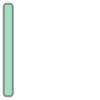

In [153]:
polygon.buffer(0.005).

In [101]:
# comparo uno a uno y genero el xr.dataset con la intersección de ambos

for intersect_name in intersecting:
    datasets[intersect_name]

(-58.30292129629628,
 -34.68307870370371,
 -58.21374537037036,
 -34.52086111111112)

In [97]:
intersecting[0]

'pansharpened_6741387101_R1C1'

In [137]:
cropped_datasets[0]

<xarray.Dataset>
Dimensions:      (band: 4, x: 2160, y: 30720)
Coordinates:
  * band         (band) int32 1 2 3 4
  * x            (x) float64 -58.3 -58.3 -58.3 -58.3 ... -58.29 -58.29 -58.29
  * y            (y) float64 -34.53 -34.53 -34.53 ... -34.67 -34.67 -34.67
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [139]:
xr.concat([datasets[ds_name], cropped_datasets[0]], dim="x")

<xarray.Dataset>
Dimensions:      (band: 4, x: 17103, y: 30720)
Coordinates:
  * band         (band) int32 1 2 3 4
  * x            (x) float64 -58.29 -58.29 -58.29 ... -58.29 -58.29 -58.29
  * y            (y) float64 -34.53 -34.53 -34.53 ... -34.67 -34.67 -34.67
    spatial_ref  int32 0
Data variables:
    band_data    (band, y, x) float32 0.0 0.0 0.0 0.0 ... 193.0 200.0 207.0

In [231]:
a = datasets[ds_name].isel(x=slice(0,1000), y=slice(0,1000))
b = datasets[ds_name].isel(x=slice(1000,2000), y=slice(0,1000))
xr.combine_by_coords([a, b])

<xarray.Dataset>
Dimensions:      (band: 4, x: 2000, y: 1000)
Coordinates:
  * band         (band) int32 1 2 3 4
  * x            (x) float64 -58.51 -58.51 -58.51 -58.51 ... -58.5 -58.5 -58.5
  * y            (y) float64 -34.61 -34.61 -34.61 ... -34.61 -34.61 -34.61
    spatial_ref  int32 0
Data variables:
    band_data    (band, y, x) float32 28.0 27.0 28.0 30.0 ... 136.0 104.0 83.0

In [129]:
xr.combine_by_coords([datasets[ds_name]] + cropped_datasets, compat="no_conflicts")

MemoryError: Unable to allocate 7.83 GiB for an array with shape (4, 30720, 17103) and data type float32

In [95]:
datasets[ds_name].sel(x=slice(xmin, xmax), y=slice(ymax, ymin))

<xarray.Dataset>
Dimensions:      (band: 4, x: 14943, y: 30720)
Coordinates:
  * band         (band) int32 1 2 3 4
  * x            (x) float64 -58.29 -58.29 -58.29 ... -58.22 -58.22 -58.22
  * y            (y) float64 -34.53 -34.53 -34.53 ... -34.67 -34.67 -34.67
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [71]:
datasets[ds_name]

<xarray.Dataset>
Dimensions:      (band: 4, x: 14943, y: 30720)
Coordinates:
  * band         (band) int32 1 2 3 4
  * x            (x) float64 -58.29 -58.29 -58.29 ... -58.22 -58.22 -58.22
  * y            (y) float64 -34.53 -34.53 -34.53 ... -34.67 -34.67 -34.67
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [40]:
for name, ds_extent in extents.items():
    print(ds_extent.buffer(0.01).intersects(extents["pansharpened_6741387101_R1C1"]))

True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
True
False
True


In [24]:
extents

{'pansharpened_6741387101_R1C1': <POLYGON ((-58.293 -34.673, -58.293 -34.531, -58.435 -34.531, -58.435 -34.67...>,
 'pansharpened_6741387101_R1C2': <POLYGON ((-58.224 -34.673, -58.224 -34.531, -58.293 -34.531, -58.293 -34.67...>,
 'pansharpened_6741387101_R2C1': <POLYGON ((-58.293 -34.815, -58.293 -34.673, -58.435 -34.673, -58.435 -34.81...>,
 'pansharpened_6741387101_R2C2': <POLYGON ((-58.224 -34.815, -58.224 -34.673, -58.293 -34.673, -58.293 -34.81...>,
 'pansharpened_6741387101_R3C1': <POLYGON ((-58.293 -34.908, -58.293 -34.815, -58.435 -34.815, -58.435 -34.90...>,
 'pansharpened_6741387101_R3C2': <POLYGON ((-58.224 -34.908, -58.224 -34.815, -58.293 -34.815, -58.293 -34.90...>,
 'pansharpened_6741390101_R1C1': <POLYGON ((-58.708 -34.397, -58.708 -34.255, -58.85 -34.255, -58.85 -34.397,...>,
 'pansharpened_6741390101_R1C2': <POLYGON ((-58.619 -34.397, -58.619 -34.255, -58.708 -34.255, -58.708 -34.39...>,
 'pansharpened_6741390101_R2C1': <POLYGON ((-58.708 -34.539, -58.708 -34.397, -5

In [17]:
{name:ds for name, ds in datasets.items() if sat_capture_names[0] in name}

{'pansharpened_6741390101_R1C1': <xarray.Dataset>
 Dimensions:      (band: 4, x: 30774, y: 30722)
 Coordinates:
   * band         (band) int32 1 2 3 4
   * x            (x) float64 -58.85 -58.85 -58.85 ... -58.71 -58.71 -58.71
   * y            (y) float64 -34.25 -34.25 -34.26 -34.26 ... -34.4 -34.4 -34.4
     spatial_ref  int32 ...
 Data variables:
     band_data    (band, y, x) float32 ...,
 'pansharpened_6741390101_R1C2': <xarray.Dataset>
 Dimensions:      (band: 4, x: 19346, y: 30722)
 Coordinates:
   * band         (band) int32 1 2 3 4
   * x            (x) float64 -58.71 -58.71 -58.71 ... -58.62 -58.62 -58.62
   * y            (y) float64 -34.25 -34.25 -34.26 -34.26 ... -34.4 -34.4 -34.4
     spatial_ref  int32 ...
 Data variables:
     band_data    (band, y, x) float32 ...,
 'pansharpened_6741390101_R2C1': <xarray.Dataset>
 Dimensions:      (band: 4, x: 30774, y: 30721)
 Coordinates:
   * band         (band) int32 1 2 3 4
   * x            (x) float64 -58.85 -58.85 -58.85 ... -5